## Configuración e importación de librerías


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import sys
import os


## Carga de los datos

El conjunto de datos de ChestX-ray8 se puede encontrar en https://nihcc.app.box.com/v/ChestXray-NIHCC/, una opción es descargar la carpeta con las imágenes en un .zip pero NIH ya proporciona .py capaz de descargar y descomprimir los archivos de las imágenes. Ese archivo ha sido modificado para descargar las imágenes en una carpeta más conveniente con la estructura del proyecto.

In [4]:
data_dir = os.path.join('..', 'data')
metadata_dir = os.path.join(data_dir, 'metadata')

In [5]:
# Check if we have all images
images_dir = os.path.join(data_dir,'images')
if not os.path.exists(images_dir):
    os.makedirs(images_dir)
# Check info
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]


print(f"Number of images: {len(image_files)}")
if len(image_files)<1:
    
    !python ../src/batch_download_zips_modifed.py
    !python ../src/unzip_images.py

Number of images: 112120


## Display Labeled Images

In [6]:
# Metadata path
metadata_file = os.path.join(metadata_dir, 'Data_Entry_2017_v2020.csv')
bbox_dir =  os.path.join(metadata_dir,'BBox_List_2017.csv')


metadata_df = pd.read_csv(metadata_file)
print(f"Unique patients: {metadata_df['Patient ID'].nunique()}")
display(metadata_df.head())


Unique patients: 30805


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


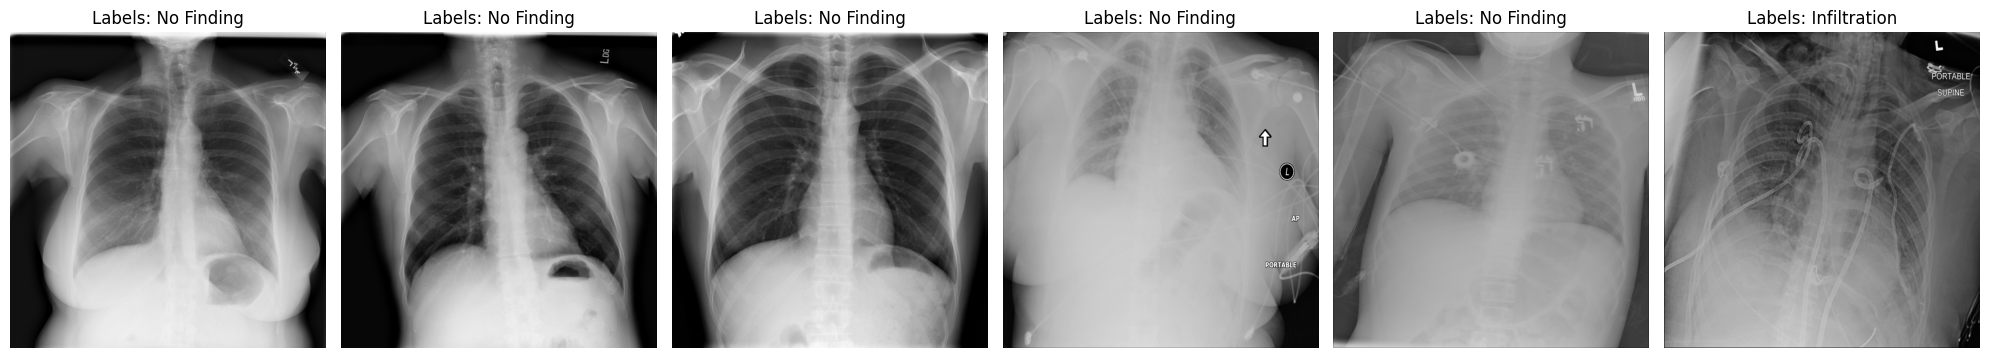

In [7]:
# Function to display sample images with labels
def display_sample_images(metadata, images_dir, n_samples=6):
    sample = metadata.sample(n_samples)
    fig, axes = plt.subplots(1, n_samples, figsize=(20, 10))
    
    for idx, (index, row) in enumerate(sample.iterrows()):
        img_path = os.path.join(images_dir, row['Image Index'])
        img = Image.open(img_path).convert("L")  # Convert to grayscale
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f"Labels: {row['Finding Labels']}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 6 random X-ray images
display_sample_images(metadata_df, images_dir, n_samples=6)


## Bounding Boxes

In [8]:
bbox_df = pd.read_csv(bbox_dir)
print("Número de imágenes con bounding boxes:", bbox_df.shape[0])
bbox_df.head()


Número de imágenes con bounding boxes: 984


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


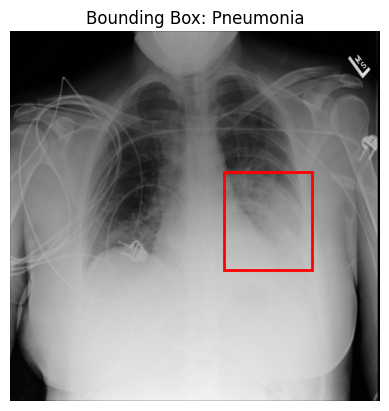

In [9]:
# Join metadata with bounding box data
bbox_sample = bbox_df.sample(1)
bbox_sample

# Visualize image with bounding box
img_path = os.path.join(images_dir, bbox_sample.iloc[0]['Image Index'])
img = Image.open(img_path).convert("L")
plt.imshow(img, cmap='gray')

# Plot bounding box
x, y, w, h = bbox_sample.iloc[0][['Bbox [x', 'y', 'w', 'h]']]
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
plt.title(f"Bounding Box: {bbox_sample.iloc[0]['Finding Label']}")
plt.axis('off')
plt.show()



## Análisis exploratorio básico

Frecuencia de Patient Gender:
Patient Gender
M    63340
F    48780
Name: count, dtype: int64



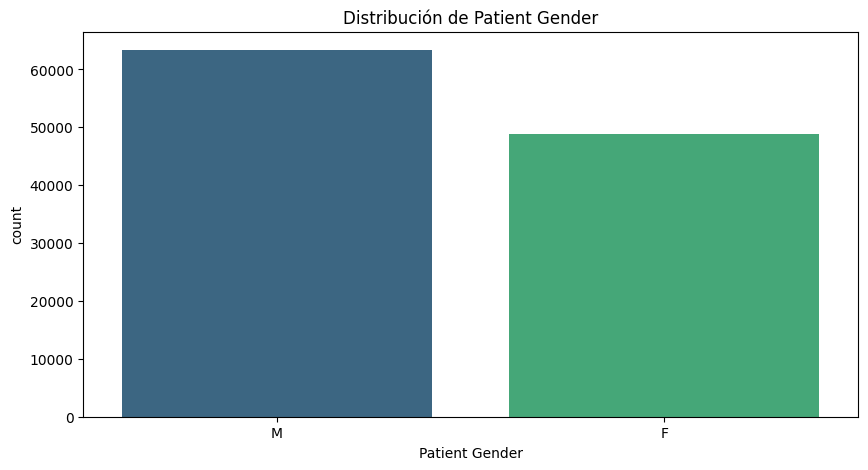

Frecuencia de View Position:
View Position
PA    67310
AP    44810
Name: count, dtype: int64



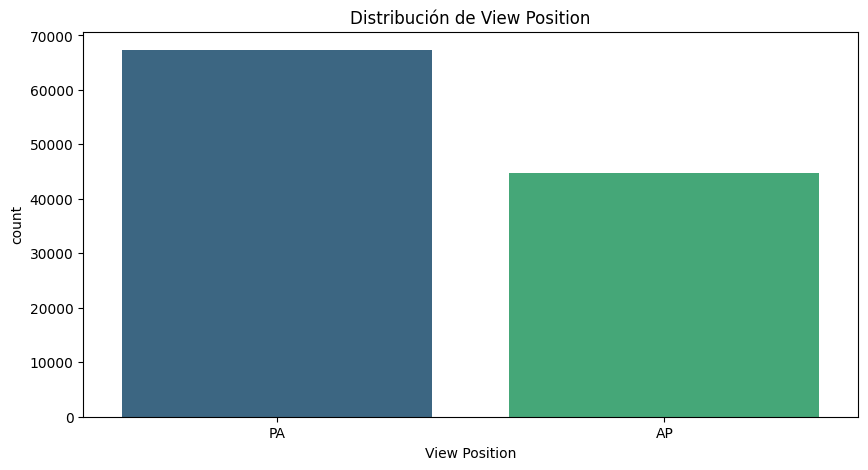

Estadísticas descriptivas de Patient Age:
count    112120.000000
mean         46.626365
std          16.602680
min           0.000000
25%          34.000000
50%          49.000000
75%          59.000000
max          95.000000
range        95.000000
Name: Patient Age, dtype: float64



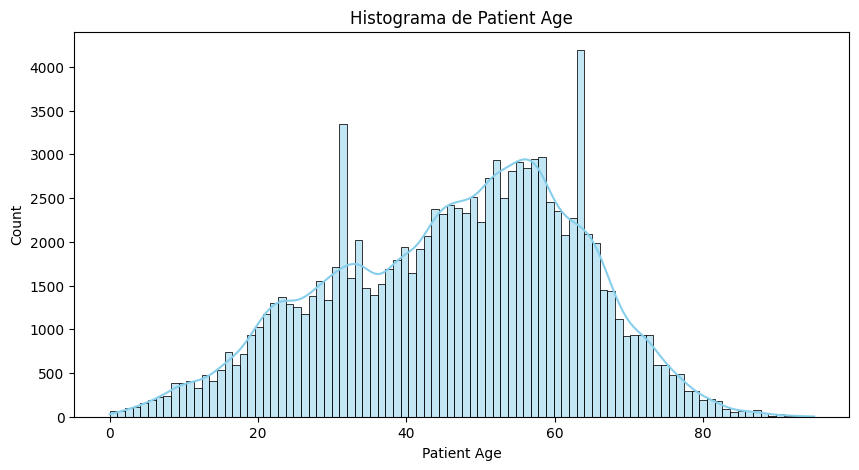

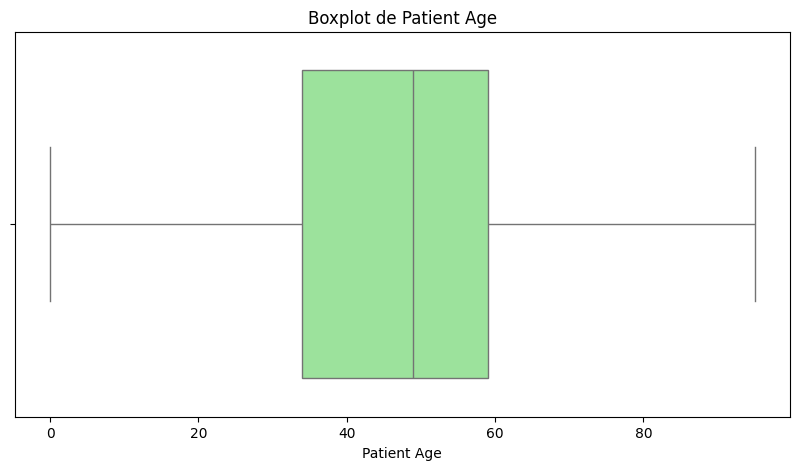

Estadísticas descriptivas de Follow-up #:
count    112120.000000
mean          8.573751
std          15.406320
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
range       183.000000
Name: Follow-up #, dtype: float64



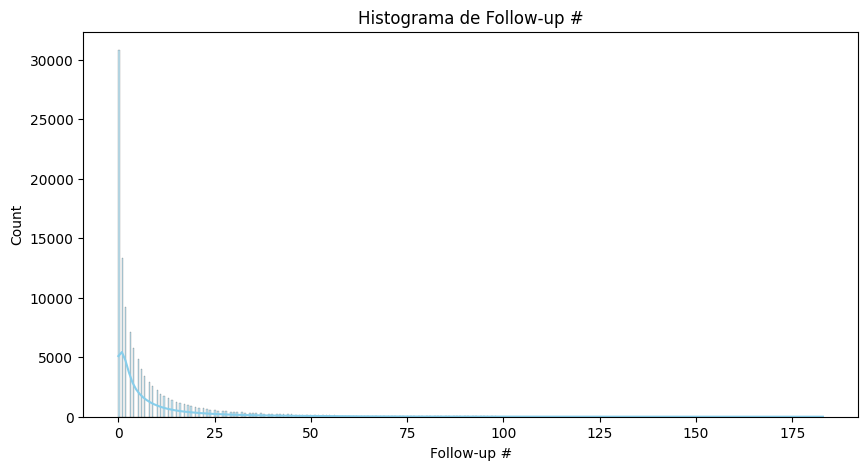

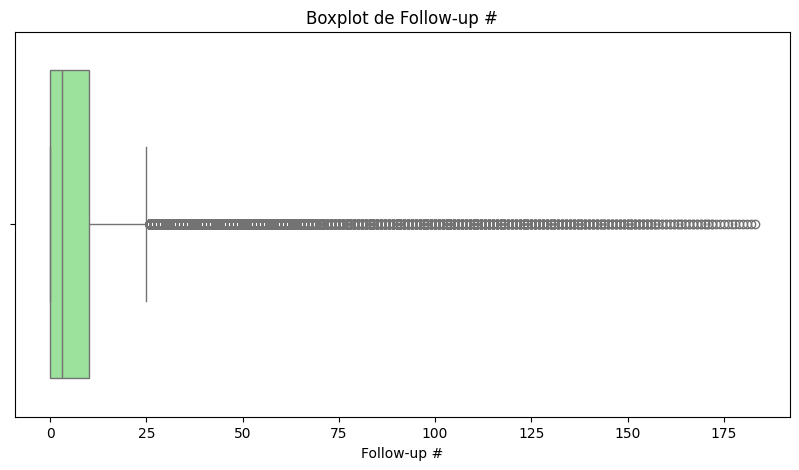

In [10]:


# Análisis de variables categóricas
categorical_vars = ['Patient Gender', 'View Position']
for var in categorical_vars:
    freq_table = metadata_df[var].value_counts()
    print(f"Frecuencia de {var}:\n{freq_table}\n")
    plt.figure(figsize=(10, 5))
    sns.countplot(data=metadata_df, x=var, hue=var, palette='viridis', legend=False)
    plt.title(f"Distribución de {var}")
    plt.show()

# Análisis de variables continuas
continuous_vars = ['Patient Age', 'Follow-up #']
for var in continuous_vars:
    desc_stats = metadata_df[var].describe()
    desc_stats['range'] = desc_stats['max'] - desc_stats['min']
    print(f"Estadísticas descriptivas de {var}:\n{desc_stats}\n")
    
    plt.figure(figsize=(10, 5))
    sns.histplot(metadata_df[var], kde=True,color='skyblue')
    plt.title(f"Histograma de {var}")
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=metadata_df[var], color='lightgreen')
    plt.title(f"Boxplot de {var}")
    plt.show()

## Análisis de las etiquetas y patologías

C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_13192\816159453.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metadata_expanded['Finding Labels'].value_counts().index, y=metadata_expanded['Finding Labels'].value_counts().values, palette='viridis')


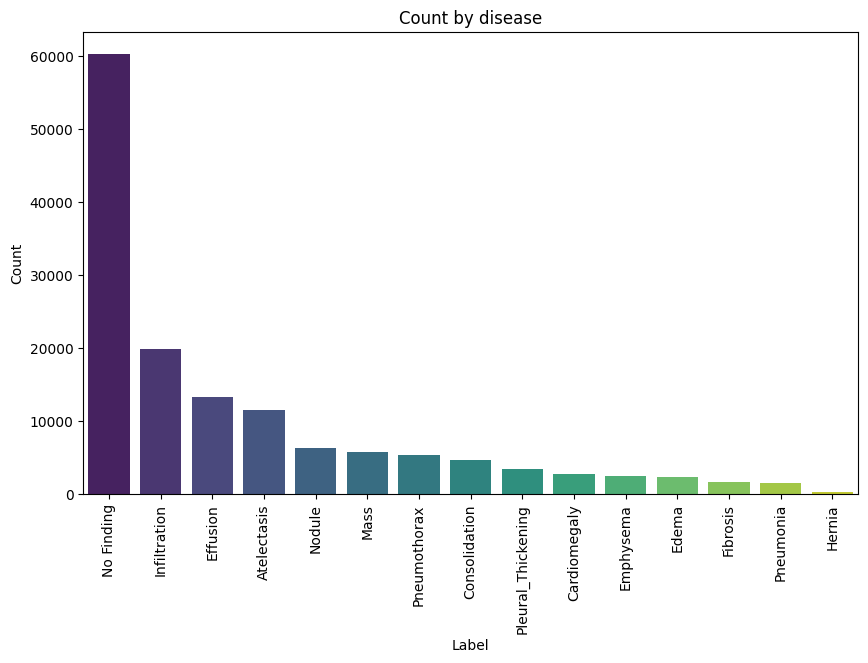

In [11]:
metadata_expanded = metadata_df.copy()
metadata_expanded['Finding Labels'] = metadata_expanded['Finding Labels'].str.split('|')
metadata_expanded = metadata_expanded.explode('Finding Labels')

plt.figure(figsize=(10, 6))
sns.barplot(x=metadata_expanded['Finding Labels'].value_counts().index, y=metadata_expanded['Finding Labels'].value_counts().values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count by disease')
plt.xticks(rotation=90)
plt.show()


Dada la frecuencia tan alta de la etiqueta No Finding, se realiza un estudio eliminando esta etiqueta:

C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_13192\1860481805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metadata_filtered['Finding Labels'].value_counts().index, y=metadata_filtered['Finding Labels'].value_counts().values, palette='viridis')


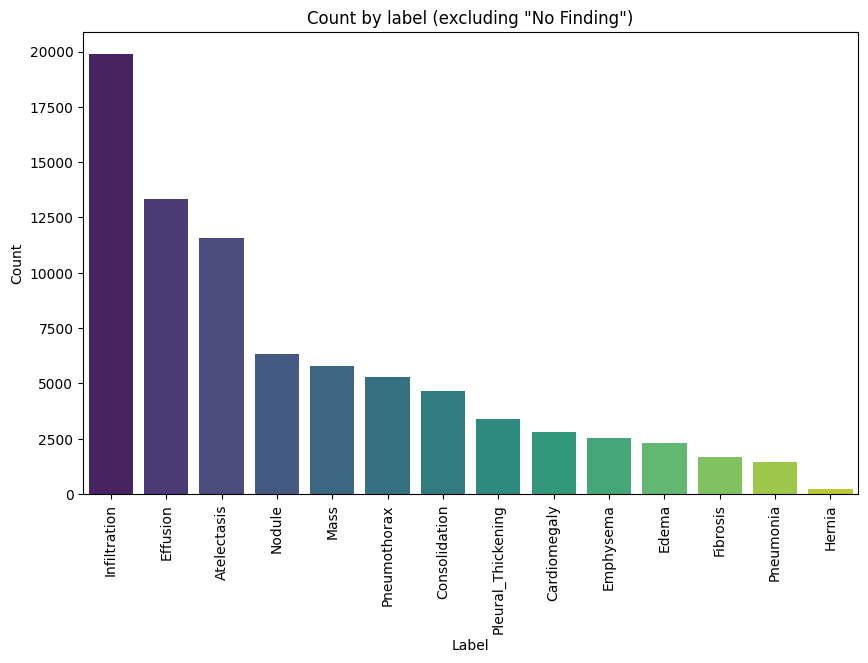

In [12]:
# Filtrar los datos para excluir 'No Finding'
metadata_filtered = metadata_expanded[metadata_expanded['Finding Labels'] != 'No Finding']

plt.figure(figsize=(10, 6))
sns.barplot(x=metadata_filtered['Finding Labels'].value_counts().index, y=metadata_filtered['Finding Labels'].value_counts().values, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count by label (excluding "No Finding")')
plt.xticks(rotation=90)
plt.show()


C:\Users\MEDHYCON\AppData\Local\Temp\ipykernel_13192\1481997400.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=patient_counts, x='Finding Labels', y='Patient Count', order=patient_counts.sort_values('Patient Count', ascending=False)['Finding Labels'], palette='viridis')


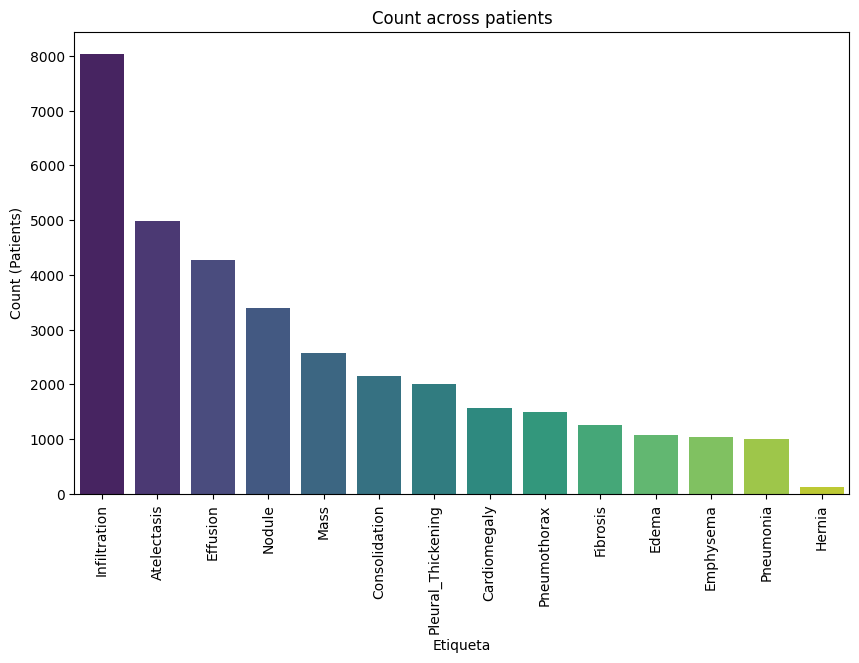

In [13]:
patient_counts = metadata_filtered.groupby('Finding Labels')['Patient ID'].nunique().reset_index()
patient_counts.columns = ['Finding Labels', 'Patient Count']

plt.figure(figsize=(10, 6))
sns.barplot(data=patient_counts, x='Finding Labels', y='Patient Count', order=patient_counts.sort_values('Patient Count', ascending=False)['Finding Labels'], palette='viridis')
plt.xlabel('Etiqueta')
plt.ylabel('Count (Patients)')
plt.title('Count across patients')
plt.xticks(rotation=90)
plt.show()

## Correlation

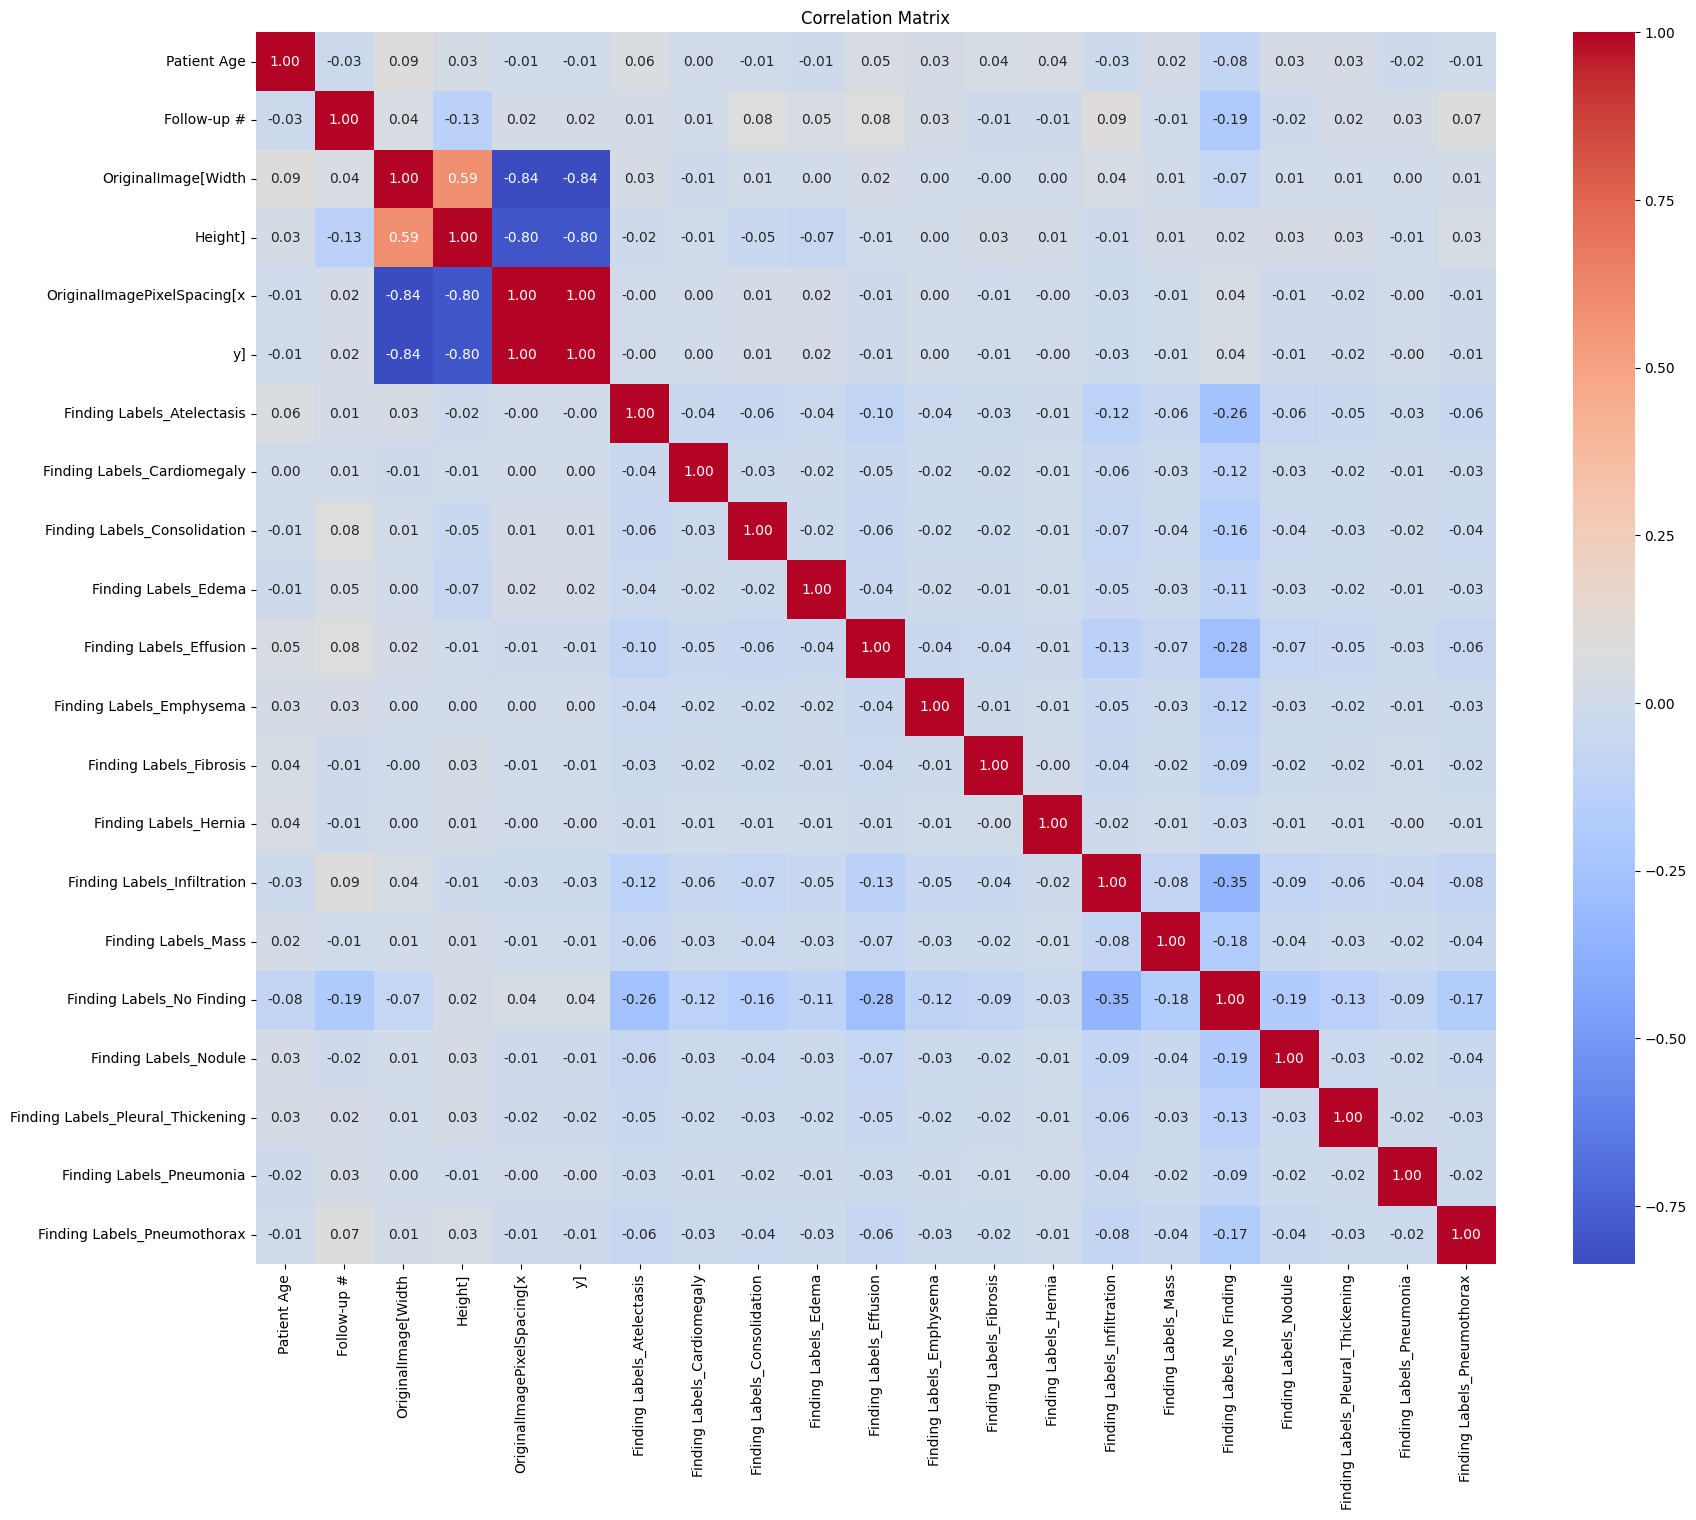

In [14]:
metadata_expanded.columns
metadata_df_encoded = pd.get_dummies(metadata_expanded, columns=['Finding Labels'])

columns_of_interest = ['Patient Age', 'Follow-up #', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]'] + \
                      [col for col in metadata_df_encoded.columns if col.startswith('Finding Labels_')]
correlation_matrix = metadata_df_encoded[columns_of_interest].corr()

# Crear el heatmap de correlación
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

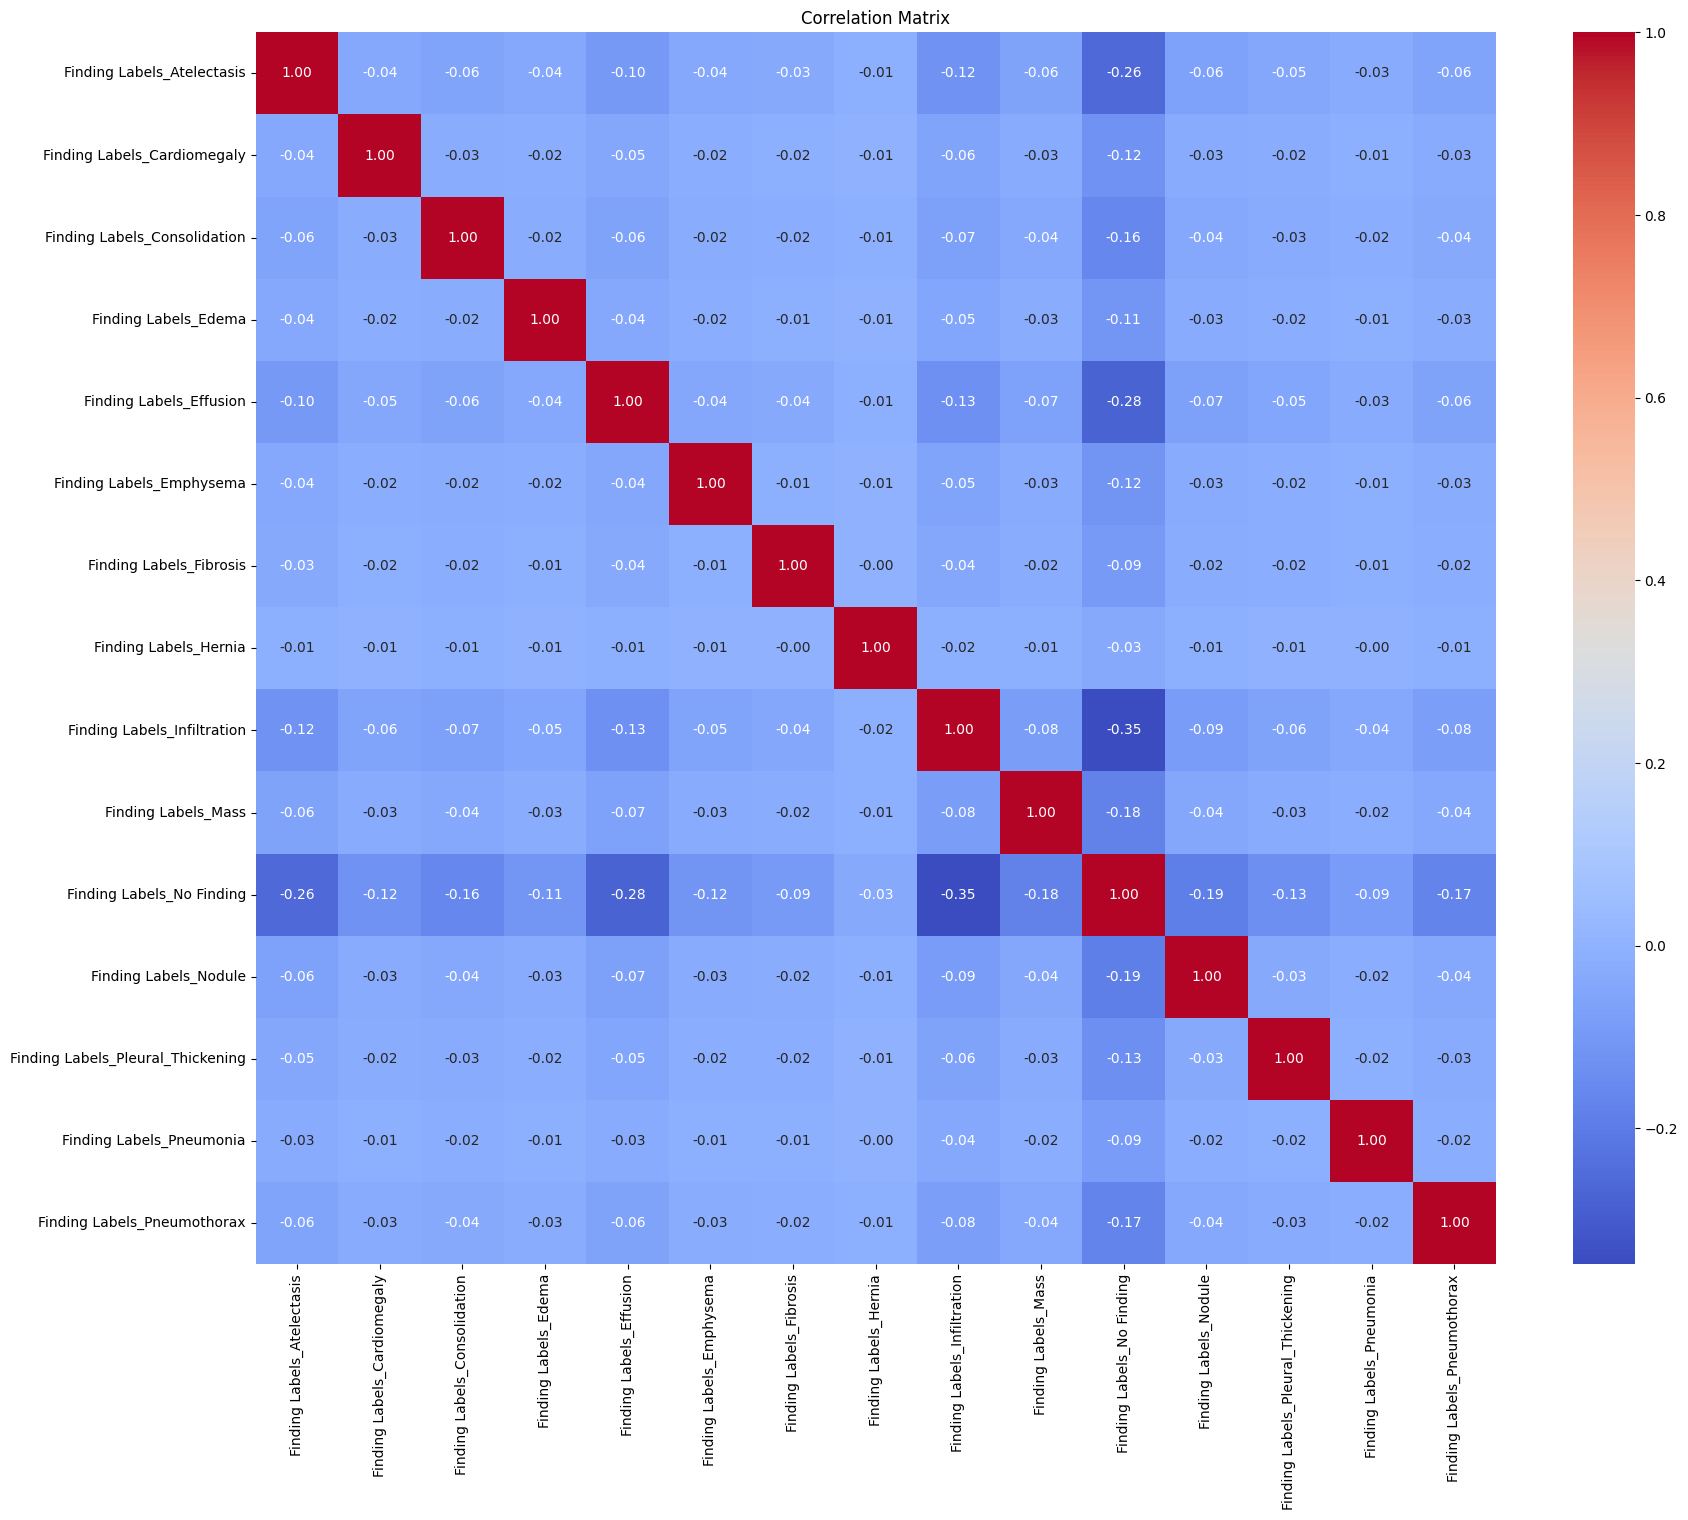

In [15]:

columns_of_interest = [col for col in metadata_df_encoded.columns if col.startswith('Finding Labels_')]
correlation_matrix = metadata_df_encoded[columns_of_interest].corr()

# Crear el heatmap de correlación
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## PCA

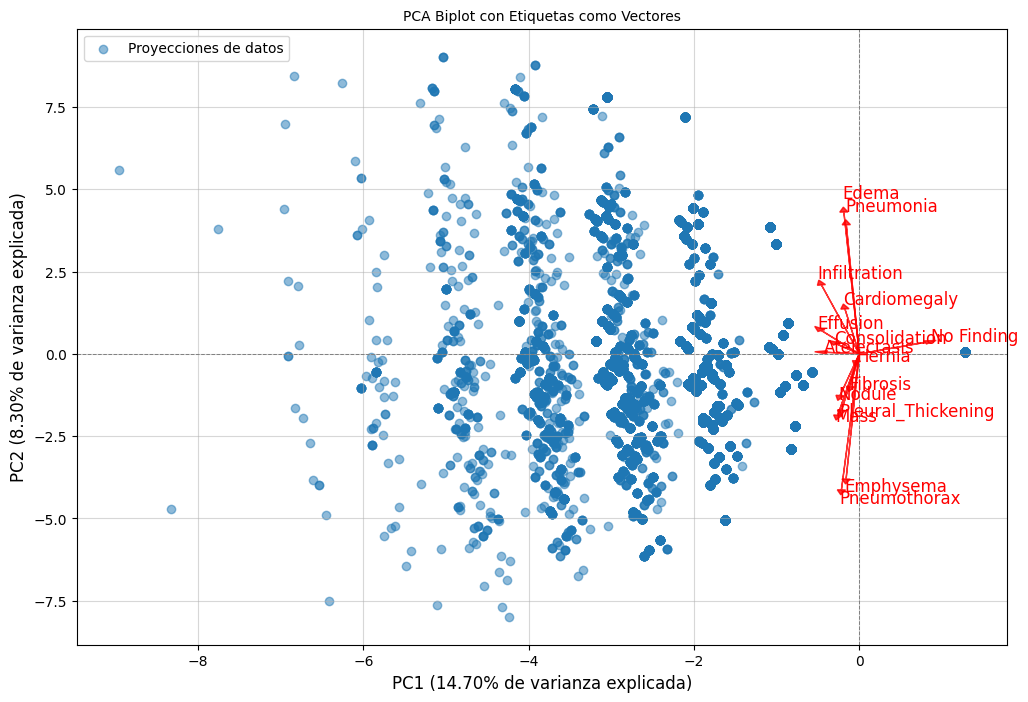

In [16]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np



from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

# Transformar etiquetas en formato binario para usarlas en PCA
mlb = MultiLabelBinarizer()
labels_binarized = mlb.fit_transform(metadata_df['Finding Labels'].str.split('|'))

# Escalar las etiquetas binarizadas
scaler = StandardScaler()
labels_scaled = scaler.fit_transform(labels_binarized)

# Aplicar PCA a las etiquetas
pca = PCA(n_components=2)
pca_result = pca.fit_transform(labels_scaled)

# Crear DataFrame para PCA
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Biplot con etiquetas como vectores
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Proyecciones de datos')

# Añadir vectores de etiquetas originales
for i, (component, label) in enumerate(zip(pca.components_.T, mlb.classes_)):
    plt.arrow(0, 0, component[0]*max(pca_df['PC1']), component[1]*max(pca_df['PC2']),
              color='r', alpha=0.8, head_width=0.1)
    plt.text(component[0]*max(pca_df['PC1'])*1.1, component[1]*max(pca_df['PC2'])*1.1, 
             label, color='r', fontsize=12)

# Configurar gráfico
plt.title('PCA Biplot con Etiquetas como Vectores', fontsize=10)
plt.xlabel('PC1 (%.2f%% de varianza explicada)' % (pca.explained_variance_ratio_[0]*100), fontsize=12)
plt.ylabel('PC2 (%.2f%% de varianza explicada)' % (pca.explained_variance_ratio_[1]*100), fontsize=12)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
plt.grid(alpha=0.5)
plt.legend()
plt.show()


## Co-ocurrence

In [19]:
import csv
from collections import Counter

finding_labels = []

for idx,row in metadata_df.iterrows():
    labels = row['Finding Labels'].split('|')
    labels.sort()  
    finding_labels.append('|'.join(labels))


label_counts = Counter(finding_labels)

most_common_combinations = label_counts.most_common()

print("Las combinaciones más comunes en 'Finding Labels' son:")
for combination, count in most_common_combinations:
    print(f"{combination}: {count} veces")

Las combinaciones más comunes en 'Finding Labels' son:
No Finding: 60361 veces
Infiltration: 9547 veces
Atelectasis: 4215 veces
Effusion: 3955 veces
Nodule: 2705 veces
Pneumothorax: 2194 veces
Mass: 2139 veces
Effusion|Infiltration: 1604 veces
Atelectasis|Infiltration: 1350 veces
Consolidation: 1310 veces
Atelectasis|Effusion: 1167 veces
Pleural_Thickening: 1126 veces
Cardiomegaly: 1093 veces
Emphysema: 892 veces
Infiltration|Nodule: 829 veces
Atelectasis|Effusion|Infiltration: 739 veces
Fibrosis: 727 veces
Edema: 628 veces
Cardiomegaly|Effusion: 484 veces
Consolidation|Infiltration: 441 veces
Infiltration|Mass: 420 veces
Effusion|Pneumothorax: 403 veces
Effusion|Mass: 402 veces
Atelectasis|Consolidation: 398 veces
Mass|Nodule: 396 veces
Edema|Infiltration: 392 veces
Infiltration|Pneumothorax: 347 veces
Emphysema|Pneumothorax: 337 veces
Consolidation|Effusion: 337 veces
Pneumonia: 322 veces
Effusion|Pleural_Thickening: 251 veces
Effusion|Nodule: 250 veces
Atelectasis|Pneumothorax: 241 